In [ ]:
!pip install --upgrade tensorflow

In [ ]:
# Step 1: Pytorch and Training Metadata
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
from torch import no_grad
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ImageDataGenerator

#hyperparameters
batch_size = 128
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000

# Architecture
num_classes = 10

#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = True

In [ ]:
# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)  # tensorboard

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

print(f"GPU available is {cuda}.")
if cuda:
      print("Running on GPU.")
else:
      print("Running on CPU or TPU (?).")

GPU available is False.
Running on CPU.


In [ ]:
import pandas as pd
import os
from glob import glob

from google.colab import drive
drive.mount('/content/mydrive')

# Check if the directory exists before trying to access it.
dir_path = '/content/mydrive/MyDrive/ELEC576_final/Data'

# debug code when trying to setup path correctly
# if os.path.exists(dir_path):
#     os.listdir(dir_path)  # List the directory's contents
# else:
#     print(f"Directory not found: {dir_path}")  # Print an informative message

# show all the files and folders in 'Data'
#print(os.listdir('/content/mydrive/MyDrive/ELEC576_final/Data'))

# Data_Entry_2017_v2020.csv from https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345 NIH CXR8 database
# has all vital information of the public available 112,120 X-RAY images with labels.
all_xray_df = pd.read_csv('/content/mydrive/MyDrive/ELEC576_final/Data/Data_Entry_2017_v2020.csv')
unique_paths = all_xray_df['Finding Labels'].unique()
print(f"Data_Entry_2017_v2020.csv is read into a df of {all_xray_df.shape}. It has {len(unique_paths)} unique 'Finding Labels'.")

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
print("Here are some data points from df before df cleaning up and preprocessing:")
all_xray_df.sample(3)

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).
Data_Entry_2017_v2020.csv is read into a df of (112120, 11). It has 836 unique 'Finding Labels'.
Here are some data points from df before df cleaning up and preprocessing:


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
41349  00010698_007.png     No Finding            7       10698           73   
70028  00017236_110.png   Infiltration          110       17236           46   
85662  00021127_015.png   Pneumothorax            4       21127           64   

      Patient Gender View Position  OriginalImage[Width  Height]  \
41349              F            AP                 2500     2048   
70028              M            AP                 2500     2048   
85662              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  path  
41349                        0.168  0.168  None  
70028                        0.168  0.168  None  
85662                        0.143  0.143  None

There are 112120 images in the database.
Total percentage of the first 15 labels is 84.27%.  Below is the detail.
**** Dataset is very imbalanced -- 'No findings' data points are over 50%. ****

               Unique Labels  Counts Percentages
0                 No Finding   60361      53.84%
1               Infiltration    9547       8.51%
2                Atelectasis    4215       3.76%
3                   Effusion    3955       3.53%
4                     Nodule    2705       2.41%
5               Pneumothorax    2194       1.96%
6                       Mass    2139       1.91%
7      Effusion|Infiltration    1603       1.43%
8   Atelectasis|Infiltration    1350       1.20%
9              Consolidation    1310       1.17%
10      Atelectasis|Effusion    1165       1.04%
11        Pleural_Thickening    1126       1.00%
12              Cardiomegaly    1093       0.97%
13                 Emphysema     892       0.80%
14       Infiltration|Nodule     829       0.74%



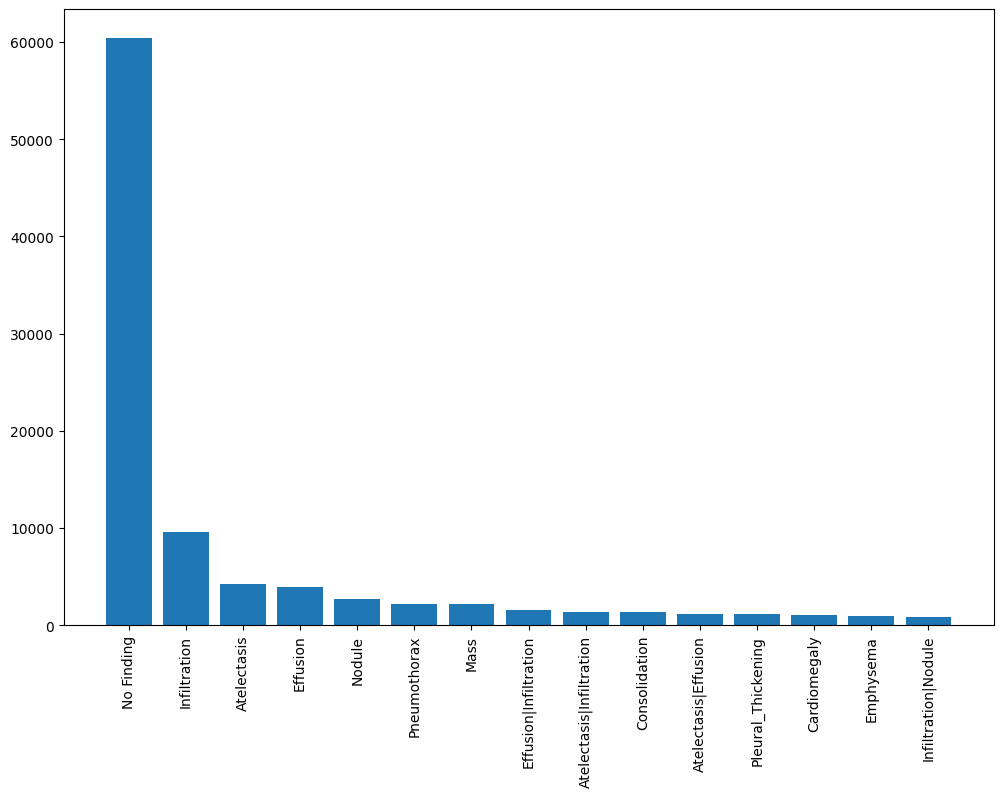

In [ ]:
import matplotlib.pyplot as plt # Importing the matplotlib.pyplot module
import numpy as np # Importing the numpy module

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

# Calculate the total number of observations
total_observations = len(all_xray_df)
print(f"There are {total_observations} images in the database.")

# Calculate the percentages
label_percentages = (label_counts / total_observations) * 100
# Calculate the total percentage of the top 15 labels
total_percentage = label_percentages.sum()
# Print the total percentage with 2 decimal places and % sign
print(f"Total percentage of the first 15 labels is {total_percentage:.2f}%.  Below is the detail.")
print("**** Dataset is very imbalanced -- 'No findings' data points are over 50%. ****\n")

label_with_info = []
for label, count in label_counts.items():
    percentage = (count / total_observations) * 100
    label_with_info.append(f"{label} ({count}, {percentage:.2f}%)")  # Use f-string for formatting

# Create a DataFrame from label_with_info
table_data = []
for label_info in label_with_info:
    label, info = label_info.split(" (")  # Split into label and (count, percentage)
    count, percentage = info[:-1].split(", ")  # Split info into count and percentage
    table_data.append([label, int(count), percentage])

df = pd.DataFrame(table_data, columns=["Unique Labels", "Counts", "Percentages"])

# Display the table
print(f"{df}\n")

fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
# preprocessing labels.

from itertools import chain

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print("Total data entries in the dataset before getting rid of all cases that have occurrences of 1000 or less :", f"{len(all_xray_df):,}")
total_cases = sum([all_xray_df[c_label].sum() for c_label in all_labels])
percentage = total_cases/len(all_xray_df)*100
print("Total data entries in the dataset after getting rid of all cases that have occurence of 1000 or less :  ", f"{int(total_cases):,}")
print(f"Percentage of data entries kept in dataset df (after dropping rare occurrences) : {percentage:.2f}%\n")

print('All Labels after dropping ({}) :\n'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# empty_label_count = all_xray_df['Finding Labels'].eq('').sum()
# print(f"Number of empty labels: {empty_label_count}")

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total data entries in the dataset before getting rid of all cases that have occurrences of 1000 or less : 112,120
Total data entries in the dataset after getting rid of all cases that have occurence of 1000 or less :   80,949
Percentage of data entries kept in dataset df (after dropping rare occurrences) : 72.20%

All Labels after dropping (13) :
 [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


The dataset df is randomly sampled and reduced to  40000 data points.
The dataset shape: (40000, 26). Its 26 columns are:
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


Image Index                                  Finding Labels  \
7867    00002059_003.png  Atelectasis|Effusion|Infiltration|Pneumothorax   
98694   00026098_015.png                                        Effusion   
111601  00030561_005.png                                    Pneumothorax   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
7867              3        2059           46              M            AP   
98694            15       26098           42              M            AP   
111601            5       30561           82              F            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
7867                   2500     2048                     0.168000  ...   
98694                  3056     2544                     0.139000  ...   
111601                 2021     2021                     0.194311  ...   

        Effusion Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
7867         1.0       0.0       0.0     0.0           1.0   0.0     0.0   
98694        1.0       0.0       0.0     0.0           0.0   0.0     0.0   
111601       0.0       0.0       0.0     0.0           0.0   0.0     0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  
7867                   0.0        0.0           1.0  
98694                  0.0        0.0           0.0  
111601                 0.0        0.0           1.0  

[3 rows x 26 columns]

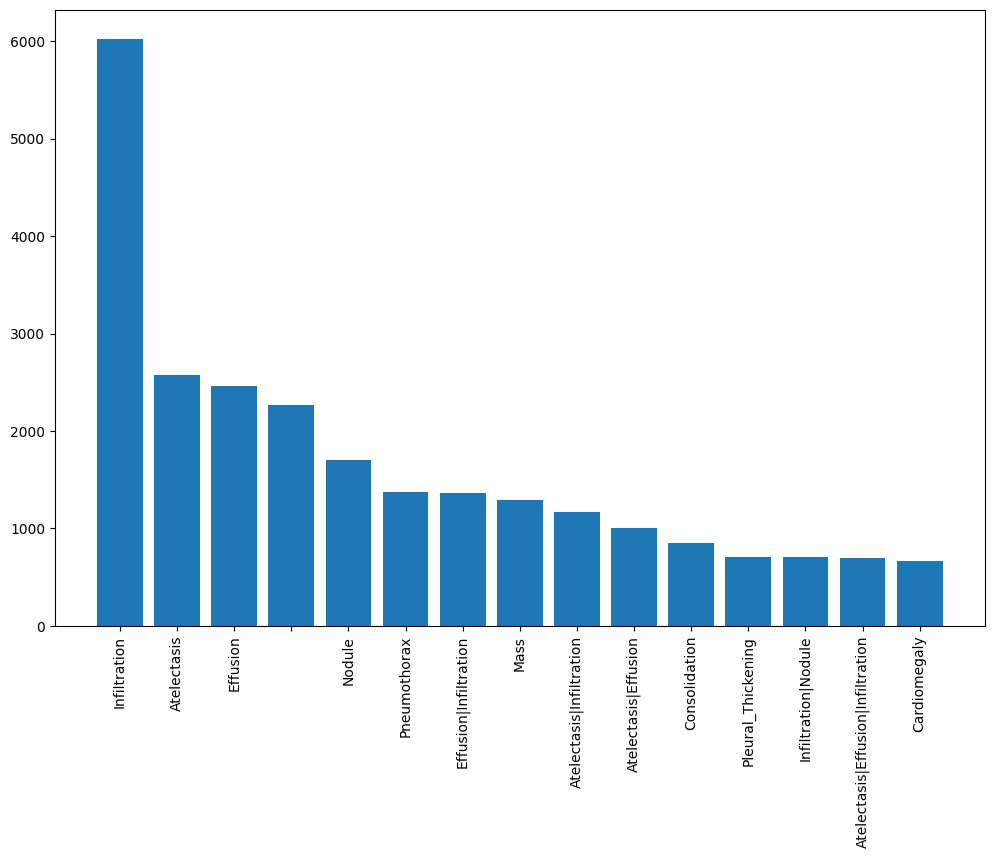

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(60000, weights=sample_weights)
#all_xray_df = all_xray_df.sample(1000, weights=sample_weights)
#all_xray_df = all_xray_df.sample(10000, weights=sample_weights)

print("The dataset df is randomly sampled and reduced to ", f"{len(all_xray_df)} data points.")
print(f"The dataset shape: {all_xray_df.shape}. Its {len(all_xray_df.columns)} columns are:\n{all_xray_df.columns}")

# the 'path' column specifies where the image png file locates.

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

all_xray_df.sample(3)

In [ ]:
#add the column to the image predicts,  a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df.shape)

55803    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
86697    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2026     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: disease_vec, dtype: object
(40000, 27)


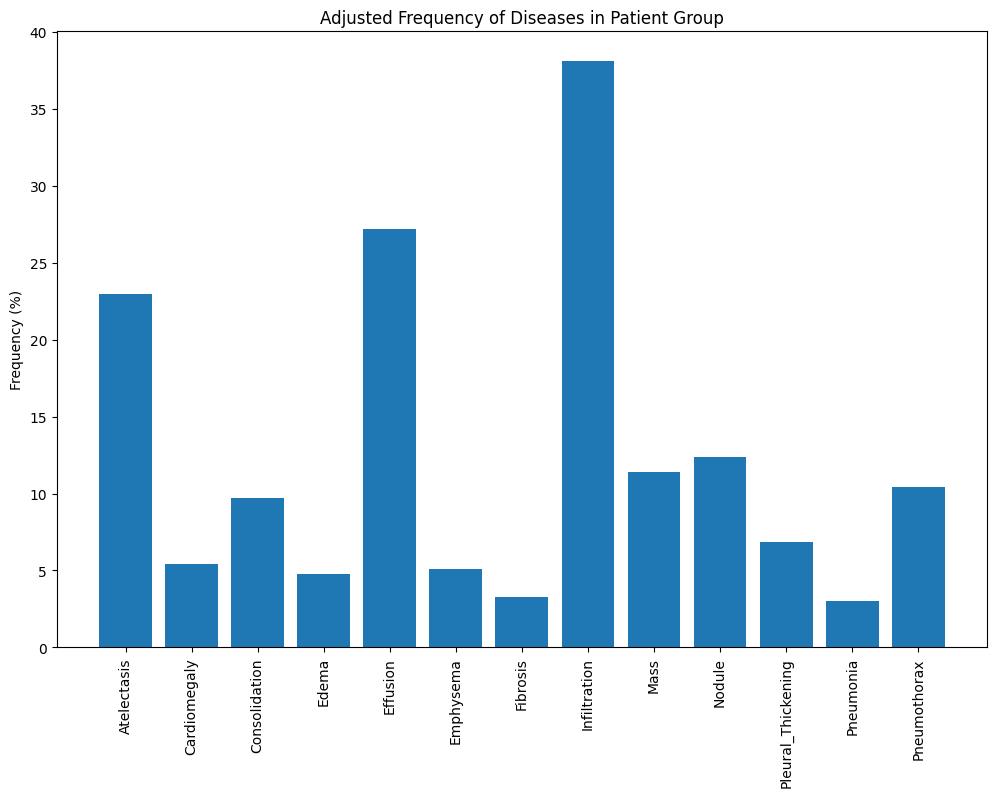

In [ ]:
#this code calculates the frequencies of diseases from patient data,
#then visualizes those frequencies as a bar chart with appropriate labels and titles.

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)

ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [ ]:
# complete the path information for each image.
#print(all_xray_df.columns)
print(all_xray_df['path'].sample(2))  # Print 2 sample paths

all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*.png'))}

# debugging 'path'
#                   glob(os.path.join('/content/mydrive/MyDrive/ELEC576/Data', 'images*', '*', '*.png'))}

# import itertools  # for islice if needed
# # Print the first 10 items (adjust as needed)
# for key, value in itertools.islice(all_image_paths.items(), 10):
#     print(f"Key: {key}, Value: {value}")

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].astype(int)
#print(all_xray_df.sample(3))
print(all_xray_df.shape)

# Check for null paths (which indicate missing files) and drop them
all_xray_df = all_xray_df.dropna(subset=['path'])

print("After dropping null paths:")
print(all_xray_df.shape)

# Check for empty strings in the 'path' column
empty_paths = all_xray_df[all_xray_df['path'] == '']

# Print the number of empty paths
print(f"Number of empty paths: {len(empty_paths)}")

# Optionally, print the rows with empty paths
if all_xray_df['path'].isnull().any() == True:
  print("problem!!!")
else:
  print("no problem")

68882    None
93665    None
Name: path, dtype: object
Scans found: 112178 , Total Headers 40000
(40000, 27)
After dropping null paths:
(40000, 27)
Number of empty paths: 0
no problem


In [ ]:
# # - download the data
# # - create the pytorch datasets
# #     scaling
# # - create pytorch dataloaders
# #     transforms
# #     batch size

# #normalize = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5,0.5,0.5])
# normalize = transforms.Normalize(mean = [0.5], std = [0.5])
# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(),
#      #transforms.RandomCrop(size = 28, padding = [0,2,3,4]),
#      transforms.RandomCrop(size = 28),
#      transforms.Grayscale(num_output_channels=1),
#      transforms.ToTensor(),
#      normalize])

# #train_dataset = datasets.CIFAR10(root = './CIFAR', train = True, transform = transform, download = True)
# #test_dataset = datasets.CIFAR10(root = './CIFAR', train = False, transform = transform, download = True)
# #train_dataset = datasets.CIFAR10(root = './content/mydrive/ELEC576_final/data/images_001', train = True, transform = transform, download = True)
# test_dataset = datasets.CIFAR10(root = './/content/mydrive/ELEC576_final/data/images_001', train = False, transform = transform, download = True)
# print(train_dataset)
# print(test_dataset)

from sklearn.model_selection import train_test_split

# "stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4])" is the crucial
# part for stratification. It ensures that the proportion of samples in each
# class (represented by the first 4 characters of the 'Finding Labels' column)
# is maintained in both the training and validation sets. This is important
# for imbalanced datasets to prevent one set from having a disproportionate
# number of samples from a particular class.

# Reducing dataset size increases the probability of the least populated class in
# y (output) has only 1 member, which is too few.  The minimum number of groups
# for any class cannot be less than 2 arises when using train_test_split with
# stratification.  This means that at least one of the classes (defined by the
# 'Finding Labels' column). has only one sample in your dataset after applying any
# filters or sampling. When you stratify the split, you are requesting that the
# train and test sets maintain the same proportion of samples from each class as
# the original dataset. However, if a class has only one sample, it is impossible
# to split it into two or more sets while preserving the proportions, leading to the error.

# Calculate the frequency of each unique label in the 'Finding Labels' column
label_frequencies = all_xray_df['Finding Labels'].value_counts()

# Filter out labels with only one occurrence
valid_labels = label_frequencies[label_frequencies > 1].index

# Create a boolean mask indicating rows with valid labels
valid_mask = all_xray_df['Finding Labels'].isin(valid_labels)

# Apply the mask to select only rows with valid labels
filtered_df = all_xray_df[valid_mask]

train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

#print(all_xray_df.sample(3))
#print(train_df.sample(3))
#print(valid_df.sample(3))
print(train_df.shape)
print(valid_df.shape)
print(train_df.columns)
#print(train_df[0])

train 30000 validation 10000
(30000, 27)
(10000, 27)
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'disease_vec'],
      dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, batch_size, **dflow_args):
    """
    Creates a generator that yields batches of image data and labels from a DataFrame.

    Args:
        img_data_gen: An ImageDataGenerator instance for data augmentation.
        in_df: The DataFrame containing image paths and labels.
        path_col: The name of the DataFrame column containing image paths.
        y_col: The name of the DataFrame column containing labels.
        **dflow_args: Additional arguments for the generator (e.g., target_size, batch_size).

    Returns:
        A generator that yields batches of image data and labels.
    """

    # Get the total number of samples
    total_samples = in_df.shape[0]

    # Create an empty list to store the images and labels
    all_data_x = []
    all_data_y = []

    # Loop through each image path in the DataFrame
    for index, row in in_df.iterrows():
        img_path = row[path_col]  # Get the image path
        img = load_img(img_path, **dflow_args)  # Load the image
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = img_data_gen.random_transform(img_array)  # Apply random transformations
        img_array = img_data_gen.standardize(img_array)  # Standardize the image

        all_data_x.append(img_array)  # Append the image to the list
        all_data_y.append(row[y_col])  # Append the label to the list

    # # Convert lists to numpy array
    # all_data_x = np.array(all_data_x)
    # all_data_y = np.array(all_data_y)

    # fit() later on complains the invalid data type.  So ...
    # Convert lists to numpy array
    all_data_x = np.array(all_data_x, dtype=np.float32)  # Explicitly set dtype to float32
    all_data_y = np.array(all_data_y, dtype=np.float32)  # Explicitly set dtype to float32

    # Create a generator from the image data and labels
    # Define a function to generate batches of data
    def data_generator(X, y, batch_size):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)
        while True:
            np.random.shuffle(indices)  # Shuffle the data
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:min(i + batch_size, num_samples)]
                yield X[batch_indices], y[batch_indices]

    # Create the generator
    generator = data_generator(all_data_x, all_data_y, batch_size)

    return generator

In [ ]:
IMG_SIZE = (128, 128)
# This ImageDataGenerator is configured to perform a variety of data augmentation techniques
# on the images, including centering, normalization, flipping, shifting, rotation,
# shearing, and zooming. These transformations help create a more diverse training dataset,
# which can lead to better generalization performance of your deep learning model.

# If any of the parameters related to augmentation (e.g., horizontal_flip,
# rotation_range, zoom_range) are set to values other
# than their defaults (usually 0 or False), then augmentation is being applied.

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

# below is without auguementataion.
# core_idg = ImageDataGenerator(samplewise_center=True,
#                               samplewise_std_normalization=True,
#                               horizontal_flip = False, #= True,
#                               vertical_flip = False,
#                               height_shift_range = 0.0, #= 0.05,
#                               width_shift_range = 0.0, # =0.1,
#                               rotation_range = 0, # =5,
#                               shear_range = 0, # = 0.1,
#                               fill_mode = 'nearest', # 'reflect',
#                               zoom_range = 0) #=0.15)

In [ ]:
# create the training data generator for the training images.
train_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 32,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )
# Below is all debugging code when trying to use data flow from directory module.
# i = 0
# for filename in train_gen.filenames:
#       i = i + 1
#       # if len(filename) < len("/content/mydrive/MyDrive/ELEC576/Data/images_012/00028974_024.png"):
#       #   print("Problem", filename)
#       #   break
#       if i %1000 == 0:
#         print(f"{i}:")
#         try:
#             print(f"filename: {filename}")
#  #           image = Image.open(filename)
#  #           print("Image opened successfully")
#             # ... process the image ...
#         except Exception as e:
#             print("Error Loading Image:", filename, e)

# Print the batch shape to confirm the batch size
#t_x, t_y = next(train_gen)
#print("Batch Shape:", t_x.shape, t_y.shape)

# Check a sample image path
# sample_path = train_df['path'].iloc[0]  # Adjust the index as needed
# print("Sample Path:", sample_path)
# print("Path Exists:", os.path.exists(sample_path))

# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
# #print(train_gen.filenames)
# print(f"train_gen.filenames len: len(train_gen.filenames)")
# print(f"train_gen.filepaths: {train_gen.filepaths}")
# print(f"train_gen.filepaths length", len(train_gen.filepaths))
# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# create training datasets X and y
# start_index = train_gen.batch_index * train_gen.batch_size
# start_index = train_gen.filepaths

# from tensorflow.keras.utils import load_img  # Import load_img
# print(f"train_gen shape: {train_gen.index_array.shape}")

# for i, j in enumerate(train_gen.index_array):
#   print("******************************************************")
#   print(f"i, j: {i}, {j}")
#   print(f"train_gen.index_array[i]: {train_gen.index_array[i]}")
#   if j == train_gen.index_array[i]:
#     print("j is the output of enumeration of train_gen.index_array")
#   else:
#     print("j is not the output of enumeration of train_gen.index_array")

#   target_index = j  # The number to find
#   positions = np.where(train_gen.index_array == target_index)[0]
#   if positions.size > 0:
#       print(f"The index {target_index} is found at position(s): {positions}")
#   else:
#       print(f"The index {target_index} is not found in index_array.")

#   if i == 10:
#     break

# print(f"train_gen.filepaths: {train_gen.filepaths}")

# iter = 0
# for j in range(30000):
#   print(f"train_gen.index_array[j]: {train_gen.filepaths_new[j]}")
#   iter += 1
#   if iter == 10:
#     break

  #img = load_img(train_gen.filepaths[j])

# end_index = min(start_index + train_gen.batch_size, train_gen.n)

# print("Starting index:", start_index)
# print("Ending index:", end_index)
# print("Batch size:", train_gen.batch_size)
# print("Total samples:", train_gen.n)

# t_x, t_y = next(train_gen)

# all_data_x = []
# all_data_y = []

# for batch_x, batch_y in train_gen:
#     print("Batch Shape:", batch_x.shape, batch_y.shape)
#     all_data_x.append(batch_x)
#     all_data_y.append(batch_y)

# # Concatenate the batches into a single dataset
# all_data_x = np.concatenate(all_data_x, axis=0)  # Adjust axis if needed
# all_data_y = np.concatenate(all_data_y, axis=0)

# t_x = all_data_x
# t_y = all_data_y

# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
#                              if n_score>0.5]))
#     c_ax.axis('off')

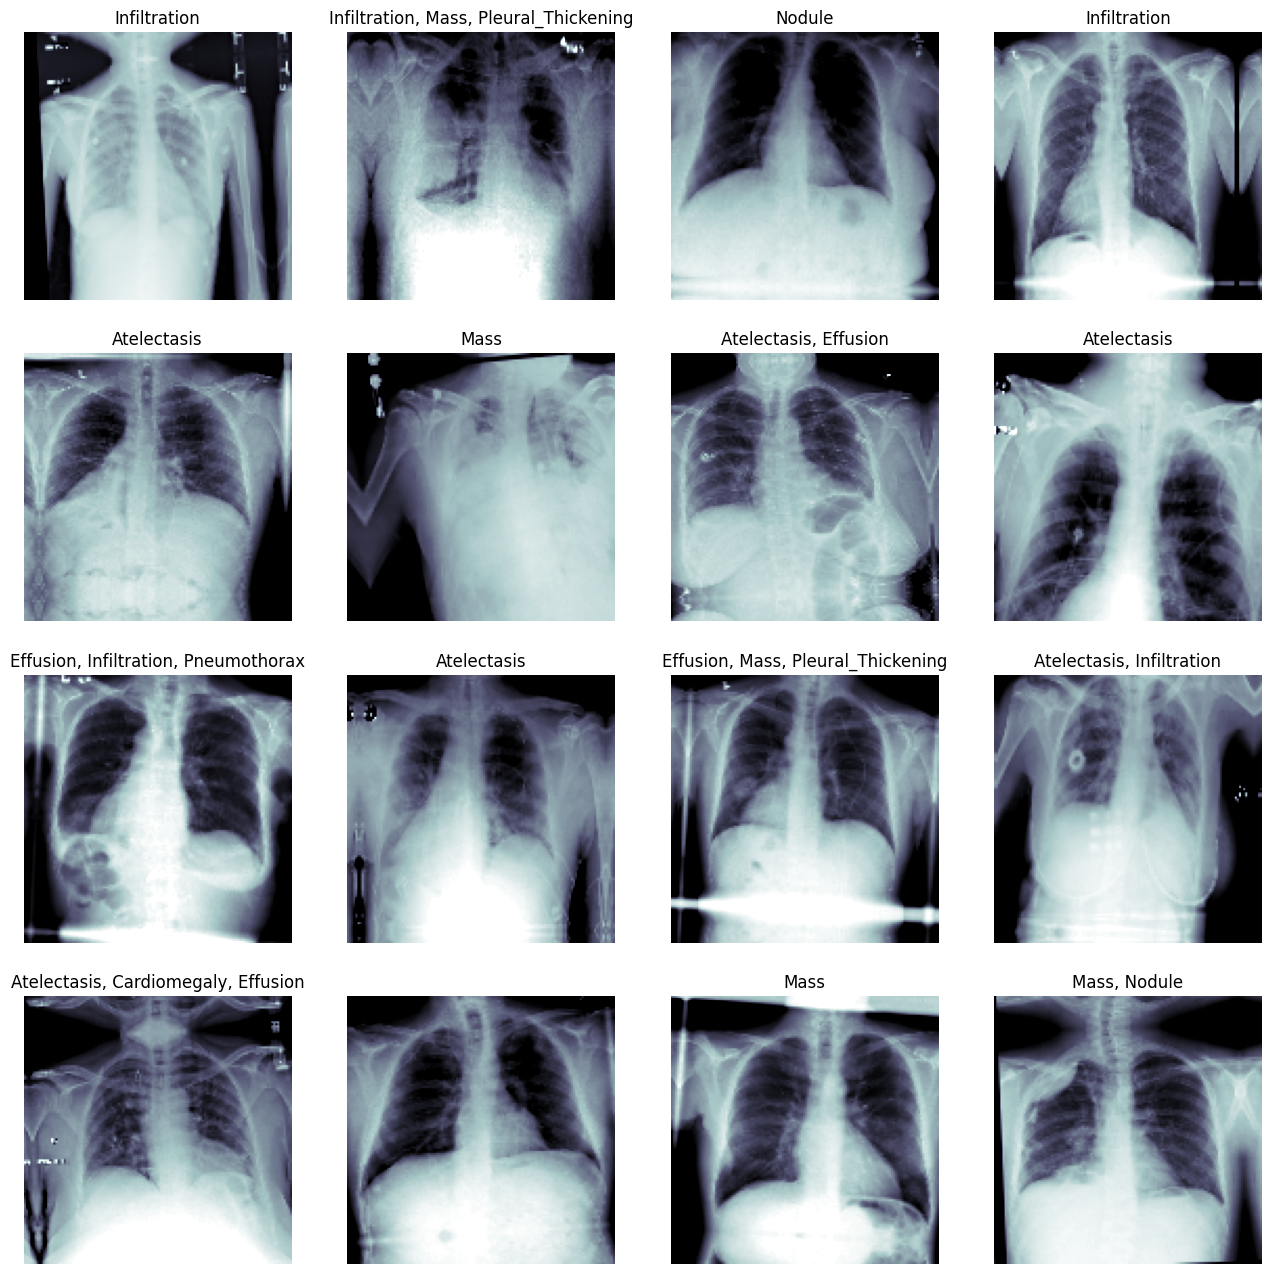

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
# create the validating data generator for the validating images.
valid_gen = flow_from_dataframe(core_idg,
                                train_df,
                                path_col = 'path',
                                y_col = 'disease_vec',
                                batch_size = 256,
                                target_size = IMG_SIZE,
                                color_mode = 'grayscale'
                                )

test_X, test_Y = next(flow_from_dataframe(core_idg,
                                          valid_df,
                                          path_col = 'path',
                                          y_col = 'disease_vec',
                                          batch_size = 1024,
                                          target_size = IMG_SIZE,
                                          color_mode = 'grayscale')) # one big batch


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, DepthwiseConv2D, Activation
from keras.models import Sequential
from tensorflow.keras import backend as K

# Loading the pre-trained MobileNet model for for feature extraction
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)

# Creating the feature extraction model by adding layers to the base model
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)

# Add the 'conv_pw_13_relu' layer (assuming it's a Depthwise Convolution with ReLU activation)
multi_disease_model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_pw_13'))
multi_disease_model.add(Activation('relu', name='conv_pw_13_relu'))

multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
# multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
#                            metrics = ['binary_accuracy', 'mae'])

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# ... (in your model compilation)
multi_disease_model.compile(optimizer = 'adam', loss = focal_loss(),
                           metrics = ['binary_accuracy', 'mae'])

multi_disease_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228288   
 onal)                                                           
                                                                 
 conv_pw_13 (DepthwiseConv2  (None, 4, 4, 1024)        10240     
 D)                                                              
                                                                 
 conv_pw_13_relu (Activatio  (None, 4, 4, 1024)        0         
 n)                                                              
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1024)             

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

# Change the file extension to .weights.h5
weight_path = weight_path.replace(".hdf5", ".weights.h5")  # Fix: Change extension to .weights.h5

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                         steps_per_epoch=100,
                         validation_data=(test_X, test_Y),
                         epochs=1,
                         callbacks=callbacks_list)

100/100 [==============================] - ETA: 0s - loss: 15.3609 - binary_accuracy: 0.8724 - mae: 0.2899
Epoch 1: val_loss improved from inf to 20.80338, saving model to xray_class_weights.best.weights.h5
100/100 [==============================] - 33s 262ms/step - loss: 15.3609 - binary_accuracy: 0.8724 - mae: 0.2899 - val_loss: 20.8034 - val_binary_accuracy: 0.8754 - val_mae: 0.3903


In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 23.63%
Cardiomegaly: 6.54%
Consolidation: 9.96%
Edema: 5.37%
Effusion: 24.80%
Emphysema: 5.18%
Fibrosis: 2.93%
Infiltration: 37.50%
Mass: 12.70%
Nodule: 11.43%
Pleural_Thickening: 6.45%
Pneumonia: 2.54%
Pneumothorax: 12.99%


In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 2s 48ms/step


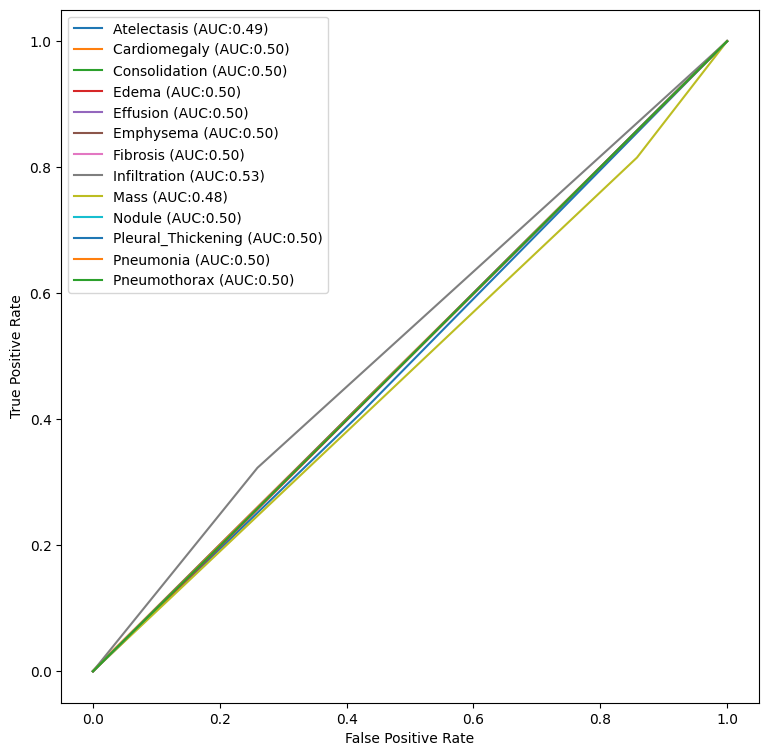

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
#  In modern Keras, the fit method is used instead and it can accept data generators directly.
# multi_disease_model.fit_generator(train_gen,
#                                   steps_per_epoch = 100,
#                                   validation_data =  (test_X, test_Y),
#                                   epochs = 5,
#                                   callbacks = callbacks_list)

multi_disease_model.fit(train_gen,  # Use fit instead of fit_generator
                        steps_per_epoch = 100,
                        validation_data =  (test_X, test_Y),
                        epochs = 5,
                        callbacks = callbacks_list)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 13.4735 - binary_accuracy: 0.8783 - mae: 0.2803
Epoch 1: val_loss improved from 20.80338 to 13.97772, saving model to xray_class_weights.best.weights.h5
100/100 [==============================] - 24s 238ms/step - loss: 13.4735 - binary_accuracy: 0.8783 - mae: 0.2803 - val_loss: 13.9777 - val_binary_accuracy: 0.8754 - val_mae: 0.3105
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 13.5646 - binary_accuracy: 0.8766 - mae: 0.2814
Epoch 2: val_loss improved from 13.97772 to 13.97278, saving model to xray_class_weights.best.weights.h5
100/100 [==============================] - 24s 238ms/step - loss: 13.5646 - binary_accuracy: 0.8766 - mae: 0.2814 - val_loss: 13.9728 - val_binary_accuracy: 0.8754 - val_mae: 0.3061
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 13.5281 - binary_accuracy: 0.8752 - mae: 0.2806
Epoch 3: val_loss improved from 13.97278 to 13.79078, saving model to xray_

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 1s 43ms/step


In [ ]:
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 23.63%, PDx: 28.85%
Cardiomegaly: Dx: 6.54%, PDx: 17.53%
Consolidation: Dx: 9.96%, PDx: 19.79%
Edema: Dx: 5.37%, PDx: 15.86%
Effusion: Dx: 24.80%, PDx: 32.22%
Emphysema: Dx: 5.18%, PDx: 19.82%
Fibrosis: Dx: 2.93%, PDx: 18.79%
Infiltration: Dx: 37.50%, PDx: 33.13%
Mass: Dx: 12.70%, PDx: 24.58%
Nodule: Dx: 11.43%, PDx: 24.78%
Pleural_Thickening: Dx: 6.45%, PDx: 22.51%
Pneumonia: Dx: 2.54%, PDx: 16.88%
Pneumothorax: Dx: 12.99%, PDx: 25.48%


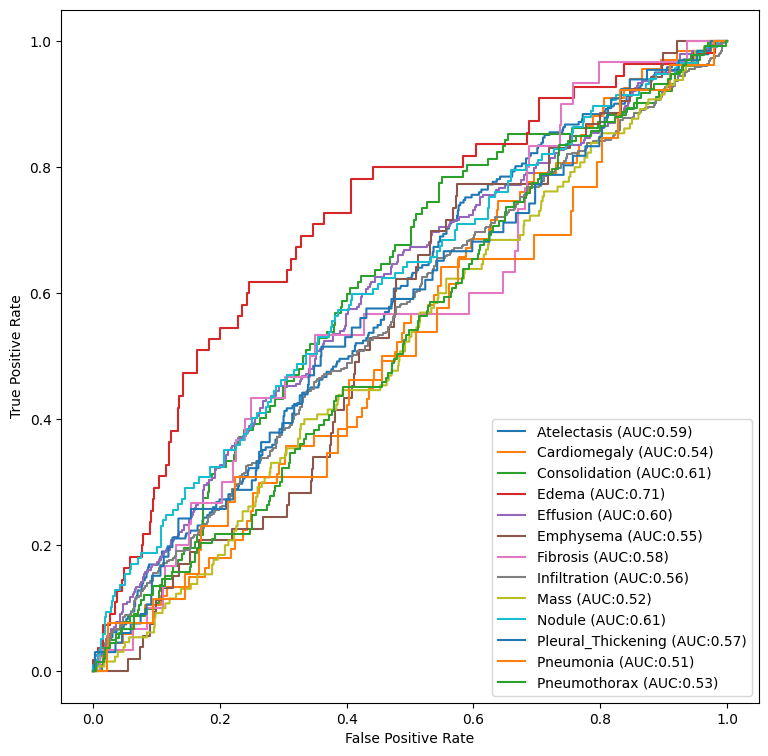

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
!pip install opencv-python
!pip install tf-keras-vis  # Install tf-keras-vis

In [ ]:
# add Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize
# the important regions in the X-ray images that contribute to the model's predictions

from tensorflow import keras
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import cm
import matplotlib.colors as mcolors
import cv2
from matplotlib.colors import Normalize

**Understanding Grad-CAM**

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used to understand which parts of an image a convolutional neural network (CNN) is focusing on when making a prediction. It essentially produces a heatmap highlighting the regions of the input image that are most important for the network's decision.

**Interpreting the Grad-CAM Heatmap**

The resulting heatmap is a visual representation of the CNN's attention. Brighter areas in the heatmap indicate regions of the image that were most important for the network's prediction. Conversely, darker areas suggest regions of lesser importance.

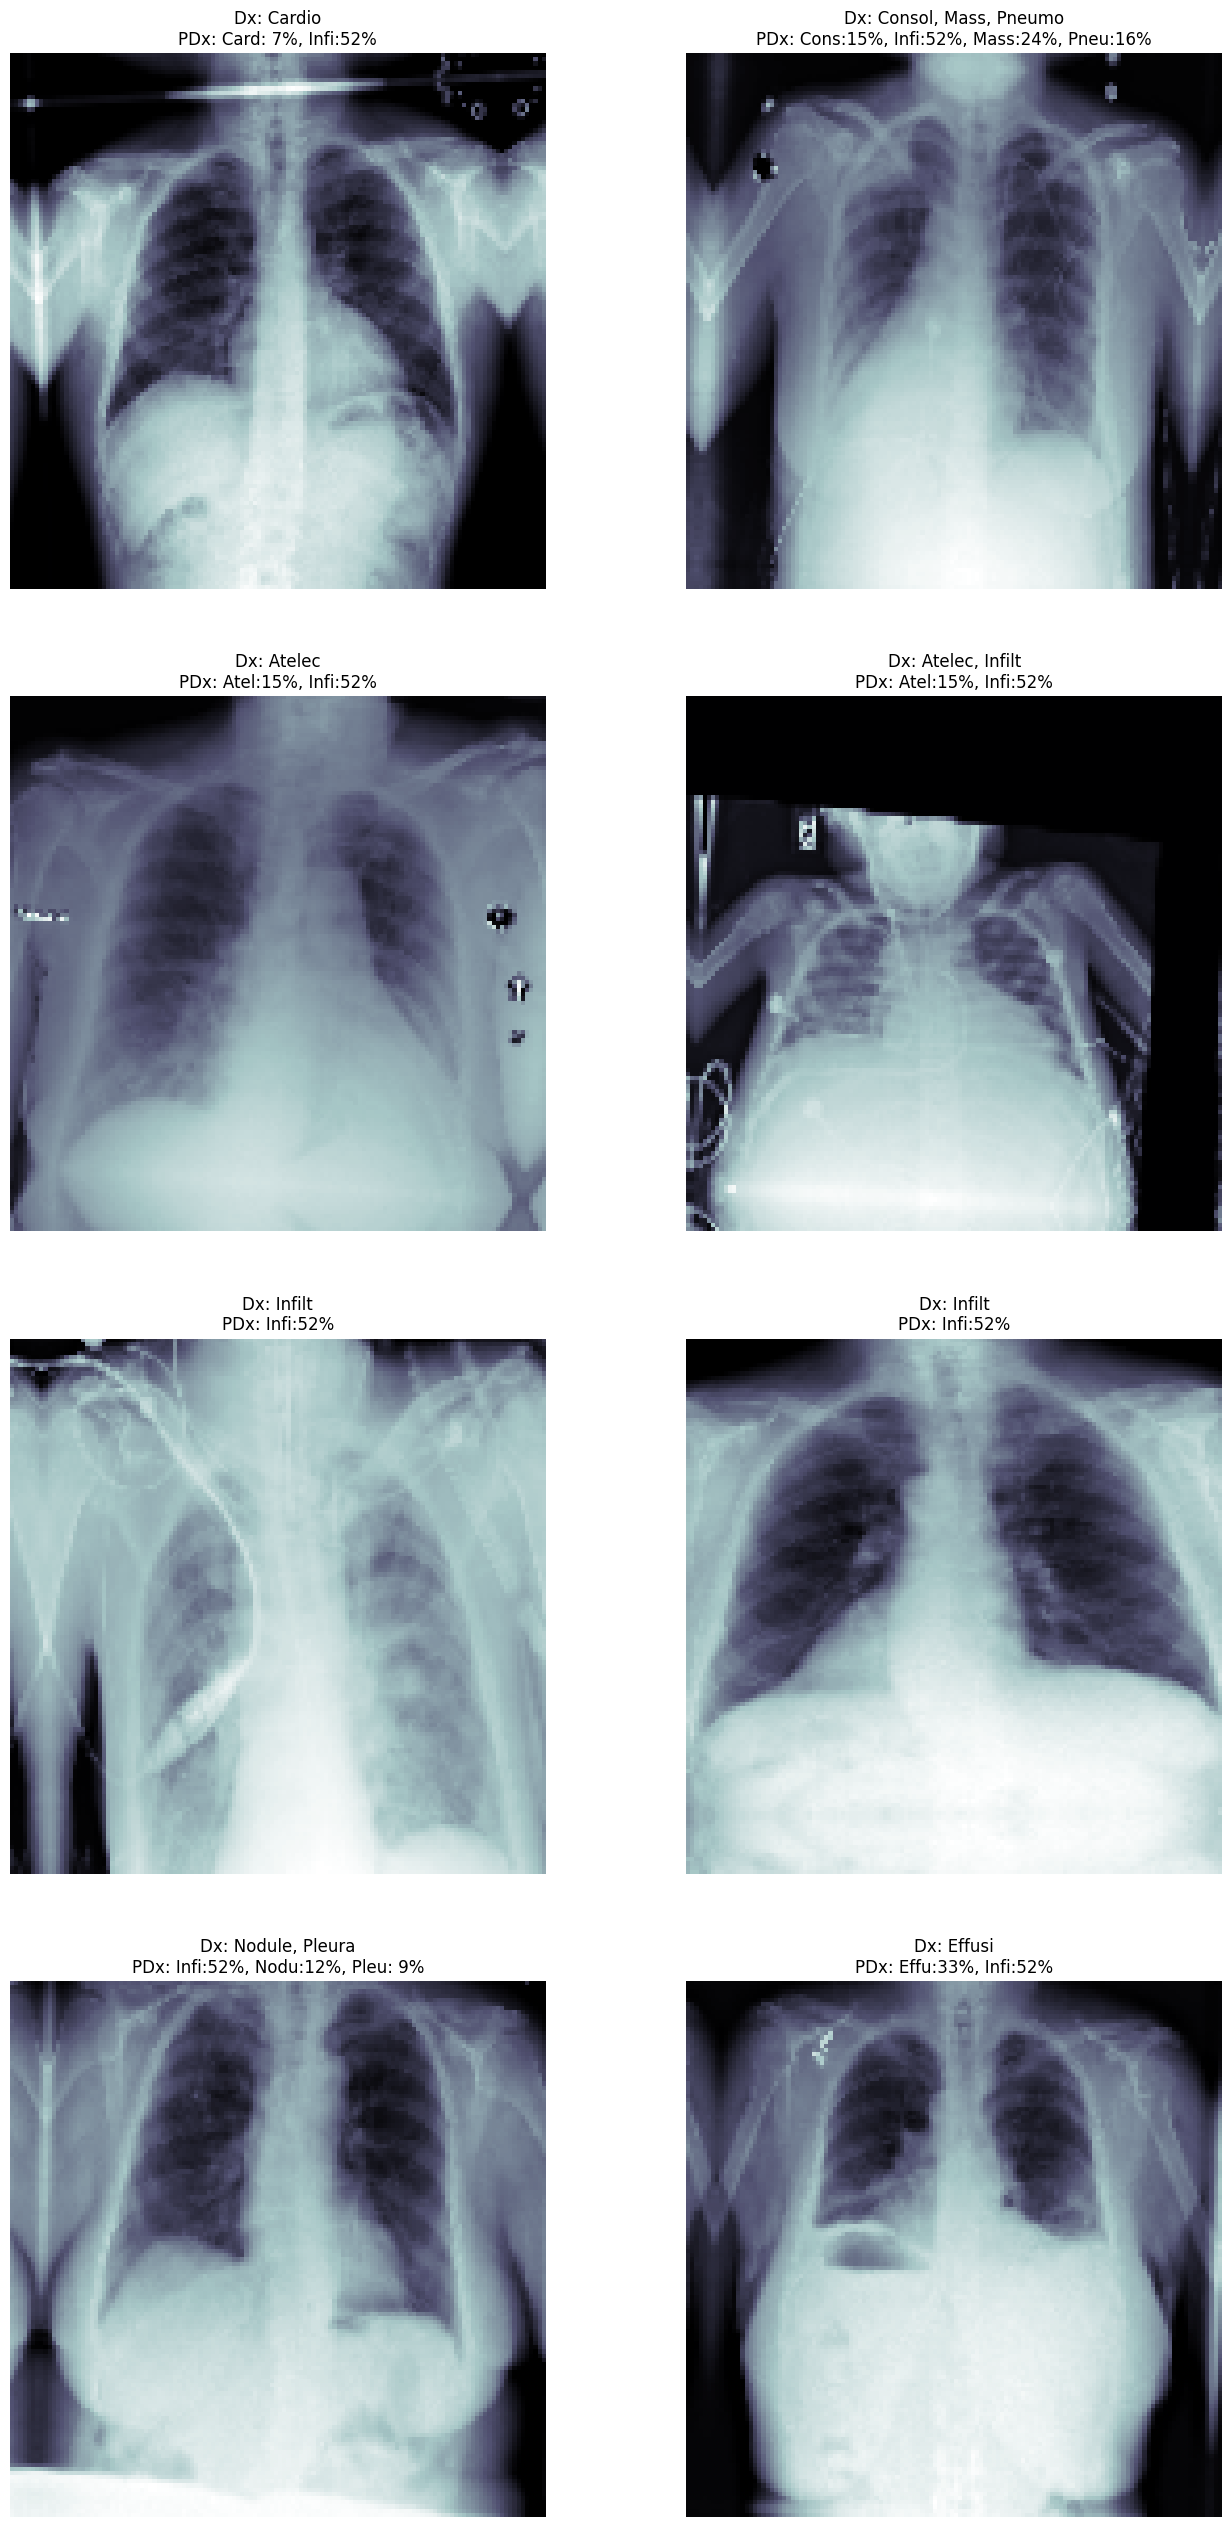

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

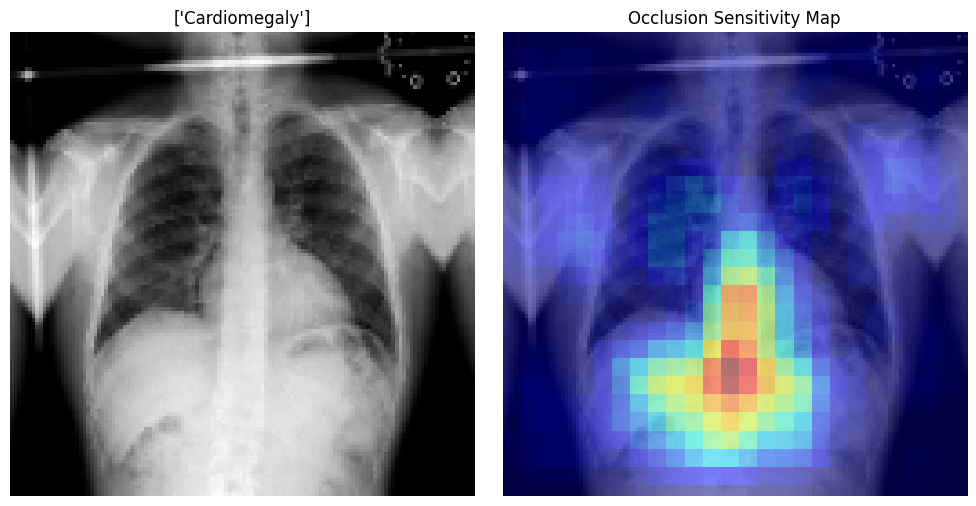

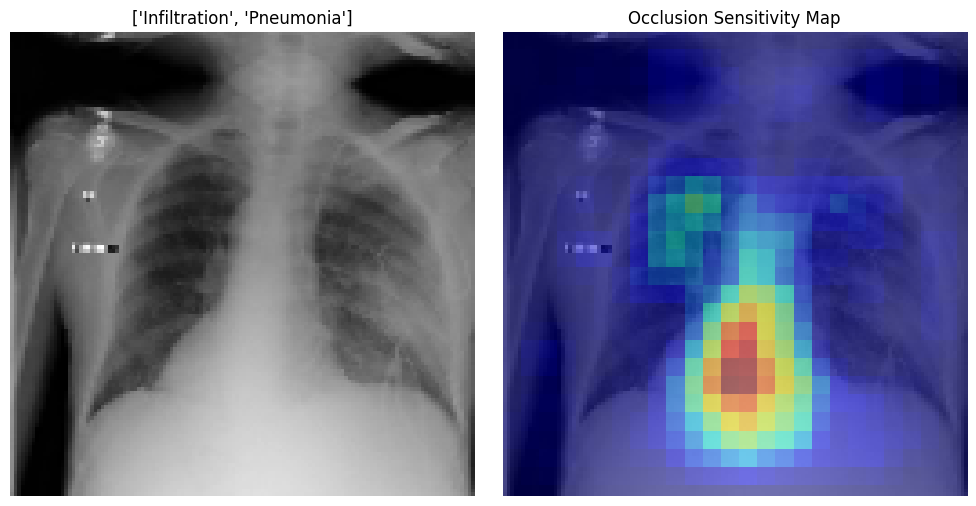

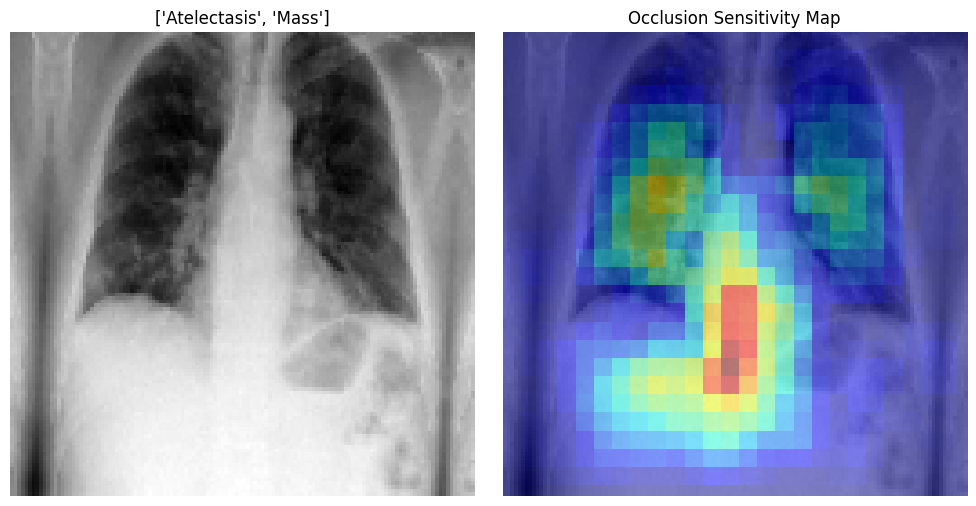

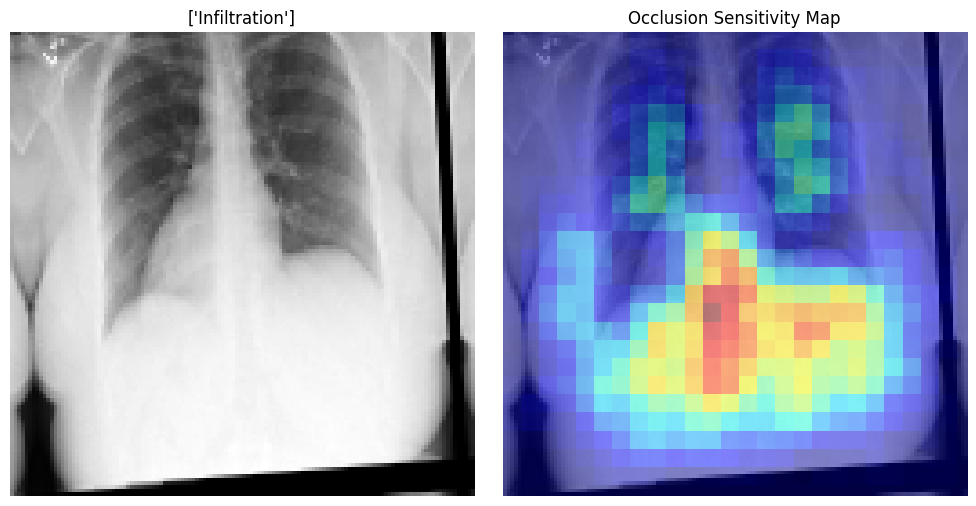

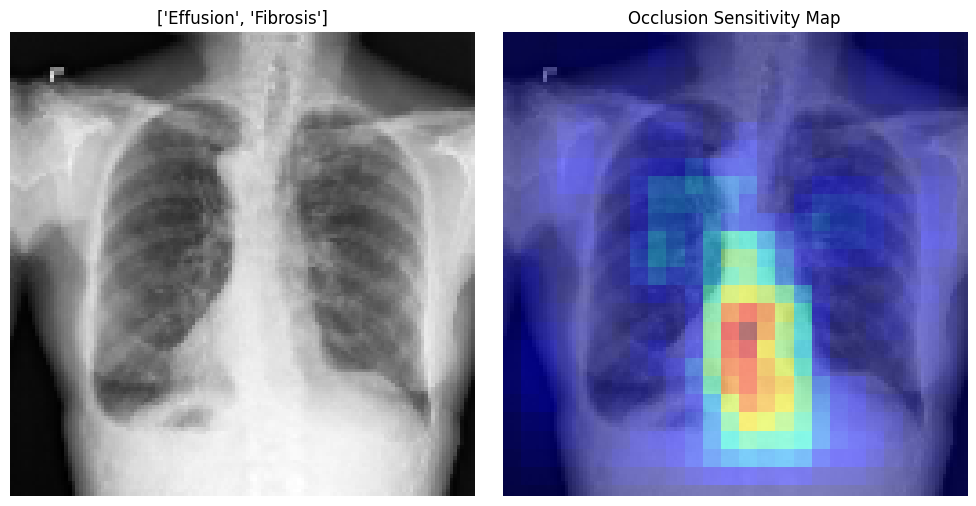

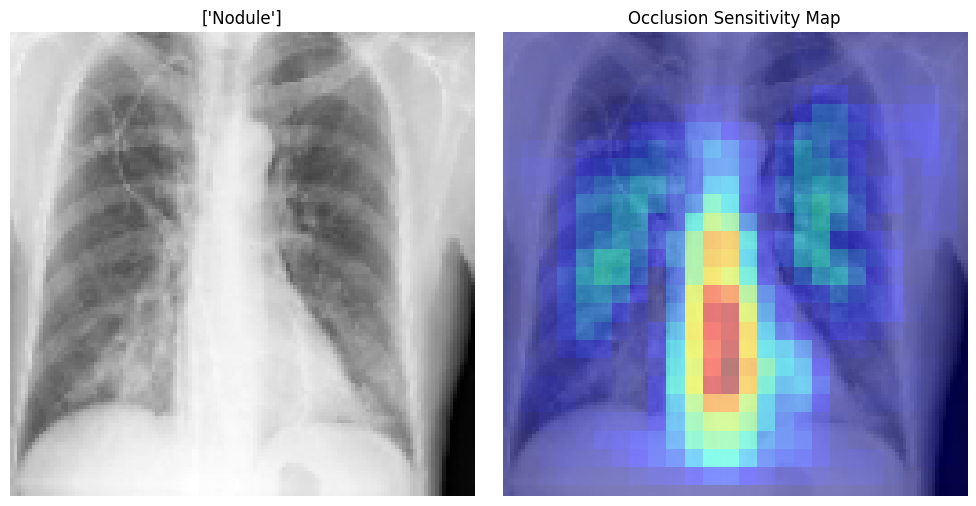

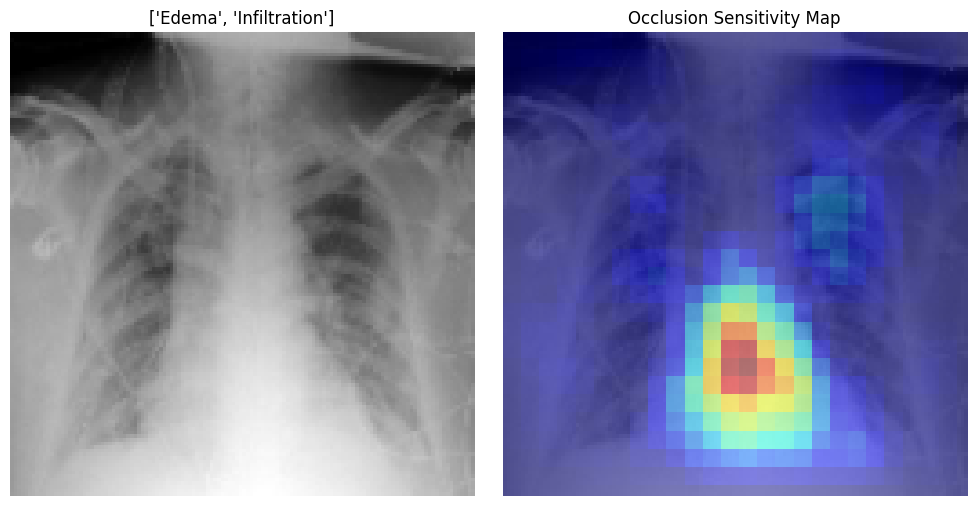

In [ ]:
def occlusion_sensitivity(model, image, patch_size=10, stride=5):
    """
    Calculates occlusion sensitivity for a given image, silencing progress messages.

    Args:
        model: The trained Keras model.
        image: The input image (NumPy array).
        patch_size: The size of the occlusion patch.
        stride: The stride for moving the patch across the image.

    Returns:
        The occlusion sensitivity map (NumPy array).
    """

    # Get the original prediction for the image, silencing progress
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
    original_prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Reset logging level

    # Initialize the occlusion sensitivity map
    occlusion_map = np.zeros_like(image[:, :, 0])

    # Iterate over patches of the image
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            # Create a copy of the image and occlude the patch
            occluded_image = image.copy()
            occluded_image[i:i + patch_size, j:j + patch_size, :] = 0

            # Get the prediction for the occluded image, silencing progress
            os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
            occluded_prediction = model.predict(np.expand_dims(occluded_image, axis=0), verbose=0)[0]
            os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Reset logging level

            # Calculate the difference in predictions
            prediction_difference = original_prediction - occluded_prediction

            # Update the occlusion sensitivity map
            occlusion_map[i:i + patch_size, j:j + patch_size] += np.max(prediction_difference)

    # Normalize the occlusion sensitivity map
    occlusion_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map))

    return occlusion_map

# Example usage:
for i in range(7):
    image = test_X[i]  # Select an image from your test set

    occlusion_map = occlusion_sensitivity(multi_disease_model, image)

    # Create a figure and axes for the side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(image[:, :, 0], cmap='gray')
    title_str = [n_class[:20] for n_class, n_score in zip(all_labels, test_Y[i])
                             if n_score>0.5]
    axes[0].set_title(title_str)
    axes[0].axis('off')  # Turn off axis labels and ticks

    # Display the occlusion sensitivity map
    axes[1].imshow(image[:, :, 0], cmap='gray')
    axes[1].imshow(occlusion_map, cmap='jet', alpha = 0.5)
    axes[1].set_title('Occlusion Sensitivity Map')
    axes[1].axis('off')

    # Show the plot
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Convert predictions to binary format (0 or 1) based on a threshold
threshold = 0.5  # Adjust as needed
pred_Y_binary = (pred_Y >= threshold).astype(int)

In [ ]:
# Calculate confusion matrix for each label
cm = multilabel_confusion_matrix(test_Y, pred_Y_binary)

# Optionally, calculate and print overall metrics
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy = accuracy_score(test_Y, pred_Y_binary)
# precision = precision_score(test_Y, pred_Y_binary, average='micro')  # or 'macro', 'weighted'
# recall = recall_score(test_Y, pred_Y_binary, average='micro')  # or 'macro', 'weighted'
# f1 = f1_score(test_Y, pred_Y_binary, average='micro')  # or 'macro', 'weighted'
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")

Accuracy: 0.0459
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


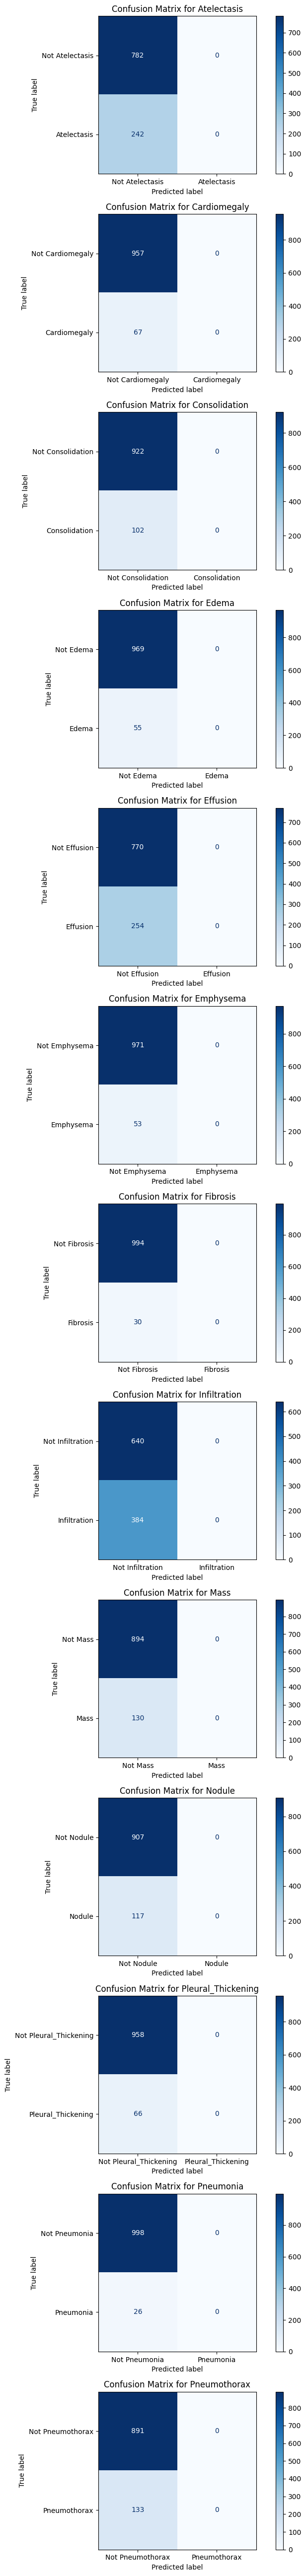

In [ ]:
fig, axes = plt.subplots(nrows=len(all_labels), ncols=1, figsize=(8, len(all_labels)*4))  # Adjust figsize as needed
for i, (label, matrix) in enumerate(zip(all_labels, cm)):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Not ' + label, label])
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for {label}')
plt.tight_layout()  # Adjust layout for better visualization
plt.show()

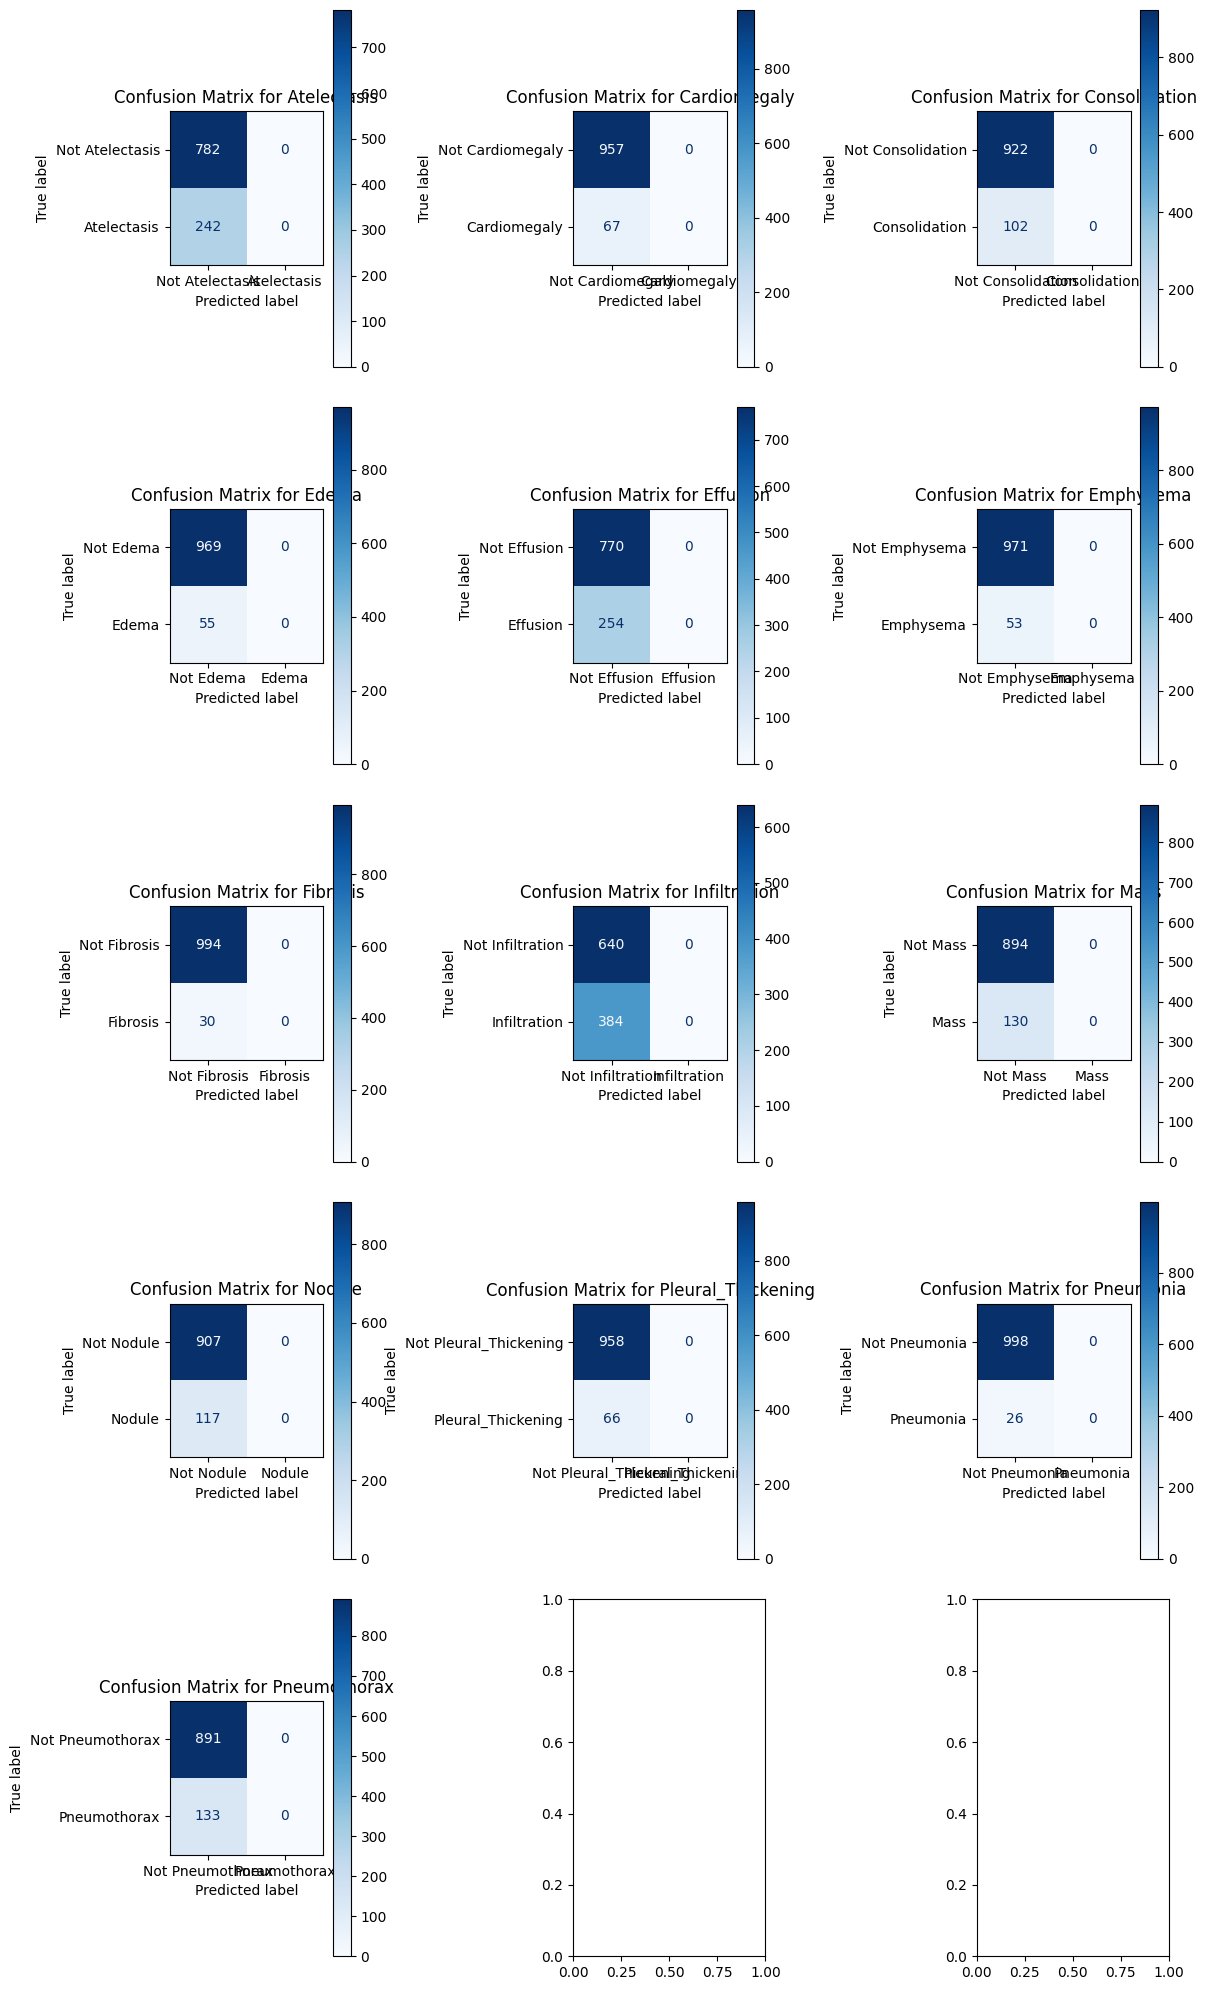

In [ ]:
# ... (previous steps to get pred_Y_binary) ...

# Calculate individual confusion matrices
cm_individual = multilabel_confusion_matrix(test_Y, pred_Y_binary)

# Visualize individual confusion matrices with subplots
num_labels = len(all_labels)
num_cols = 3  # Adjust number of columns as needed
num_rows = int(np.ceil(num_labels / num_cols))
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, num_rows * 4))  # Adjust figsize as needed
for i, (label, matrix) in enumerate(zip(all_labels, cm_individual)):
    row = i // num_cols
    col = i % num_cols
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Not ' + label, label])
    disp.plot(ax=axes[row, col], values_format='d', cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for {label}')
plt.tight_layout()
plt.show()

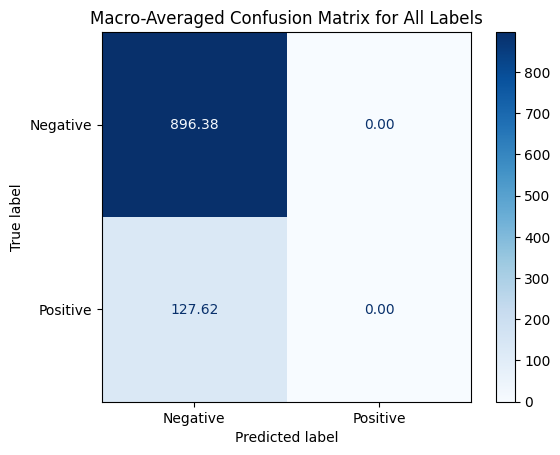

In [ ]:
# ... (previous steps to get pred_Y_binary) ...

# Calculate individual confusion matrices
cm_individual = multilabel_confusion_matrix(test_Y, pred_Y_binary)

# Macro-averaged confusion matrix
cm_macro_averaged = np.mean(cm_individual, axis=0)

# Visualize macro-averaged confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_macro_averaged, display_labels=['Negative', 'Positive'])
disp.plot(values_format='.2f', cmap='Blues')  # Use float format for averaged values
disp.ax_.set_title('Macro-Averaged Confusion Matrix for All Labels')
plt.show()

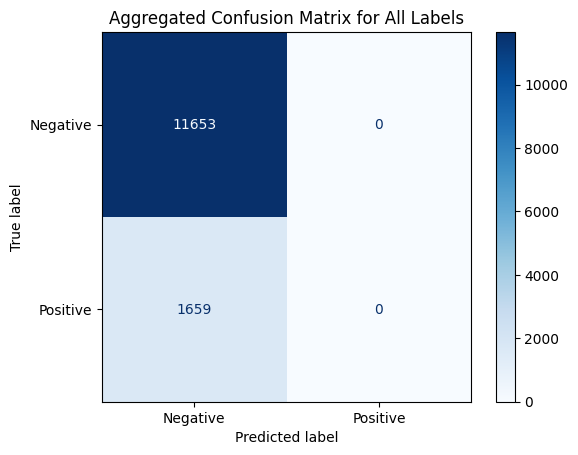

In [ ]:
# Calculate individual confusion matrices
cm_individual = multilabel_confusion_matrix(test_Y, pred_Y_binary)

# Aggregate confusion matrix
cm_aggregated = np.sum(cm_individual, axis=0)

# Visualize aggregated confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=['Negative', 'Positive'])
disp.plot(values_format='d', cmap='Blues')
disp.ax_.set_title('Aggregated Confusion Matrix for All Labels')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_large_confusion_matrix(cm, labels):
    """Visualizes a large confusion matrix using seaborn heatmap."""
    plt.figure(figsize=(12, 10))  # Adjust figure size as needed
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (13x13)")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.yticks(rotation=0)  # Keep y-axis labels vertical
    plt.tight_layout()
    plt.show()

# Assuming you have your 13x13 confusion matrix 'cm' and labels 'all_labels'
# ... (previous steps to calculate cm) ...

visualize_large_confusion_matrix(cm, all_labels)

ValueError: Must pass 2-d input. shape=(13, 2, 2)

<Figure size 1200x1000 with 0 Axes>

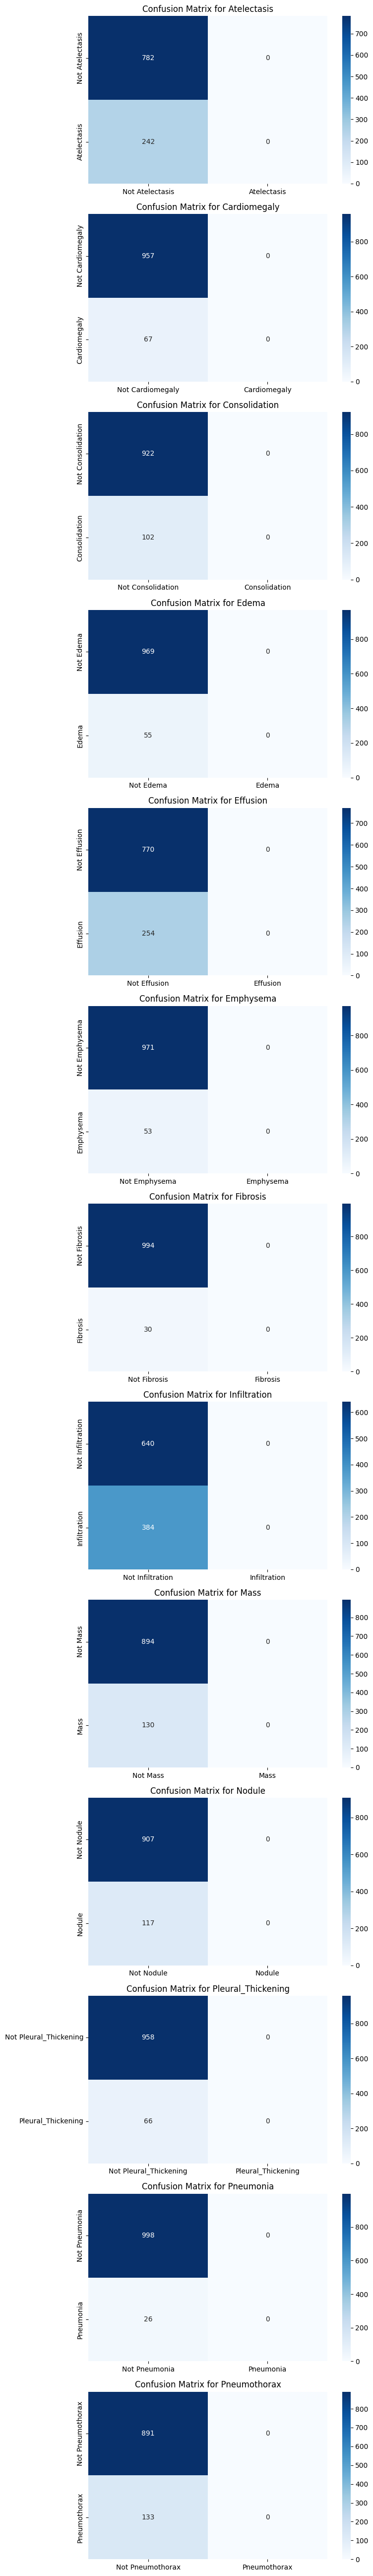

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_large_confusion_matrix(cm, labels):
    """Visualizes a large confusion matrix using seaborn heatmap."""
    # cm is expected to have shape (n_labels, 2, 2)
    num_labels = cm.shape[0]  # Get the number of labels

    fig, axes = plt.subplots(nrows=num_labels, ncols=1, figsize=(8, num_labels * 4))

    for i, (label, matrix) in enumerate(zip(labels, cm)):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Not ' + label, label], yticklabels=['Not ' + label, label],
                    ax=axes[i])  # Plot on the corresponding subplot
        axes[i].set_title(f'Confusion Matrix for {label}')

    plt.tight_layout()
    plt.show()

# Assuming you have your 13x13 confusion matrix 'cm' and labels 'all_labels'
# ... (previous steps to calculate cm) ...

visualize_large_confusion_matrix(cm, all_labels)